In [15]:
with open('deu.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
print("文档总共有 {} 行。".format(len(lines)))
num_samples = 180000  # 使用的语料行数
lines_to_use = lines[: min(num_samples, len(lines) - 1)]
# print(lines_to_use)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [2]:
import re

# print(lines_to_use[19516])
for i in range(len(lines_to_use)):
    lines_to_use[i] = re.sub('\d', ' _NUMBER_ ', lines_to_use[i])
    # 用 ' _NUMBER_ ' 替换 数字（\d）
# print(lines_to_use[19516])
input_texts = []
target_texts = []
input_words = set()
target_words = set()
for line in lines_to_use:
    x, y = line.split('\t')
    y = 'BEGIN_ ' + y + ' _END'
    input_texts.append(x)
    target_texts.append(y)
    for word in x.split():
        if word not in input_words:
            input_words.add(word)
    for word in y.split():
        if word not in target_words:
            target_words.add(word)

In [3]:
max_input_seq_len = max([len(seq.split()) for seq in input_texts])
# 11
max_target_seq_len = max([len(seq.split()) for seq in target_texts])
# 15

input_words = sorted(list(input_words))
target_words = sorted(list(target_words))
num_encoder_tokens = len(input_words)  # 5724
num_decoder_tokens = len(target_words)  # 9126

In [4]:
inputToken_idx = {token: i for (i, token) in enumerate(input_words)}
outputToken_idx = {token: i for (i, token) in enumerate(target_words)}
idx_inputToken = {i: token for (i, token) in enumerate(input_words)}
idx_outputToken = {i: token for (i, token) in enumerate(target_words)}

In [5]:
import numpy as np

encoder_input_data = np.zeros(
    (len(input_texts), max_input_seq_len),
    # 句子数量，         最大输入句子长度
    dtype=np.float32
)

decoder_input_data = np.zeros(
    (len(target_texts), max_target_seq_len),
    # 句子数量，          最大输出句子长度
    dtype=np.float32
)

decoder_output_data = np.zeros(
    (len(target_texts), max_target_seq_len, num_decoder_tokens),
    # 句子数量，          最大输出句子长度,      输出 tokens ids 个数
    dtype=np.float32
)

c:\program files\python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\program files\python37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\program files\python37\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [6]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = inputToken_idx[word]
    for t, word in enumerate(target_text.split()):
        decoder_input_data[i, t] = outputToken_idx[word]
        if t > 0:
            # 解码器的输出比输入提前一个时间步
            decoder_output_data[i, t - 1, outputToken_idx[word]] = 1.

In [7]:
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

embedding_size = 512  # 嵌入维度
rnn_size = 128
# 编码器
encoder_inputs = Input(shape=(None,))
encoder_after_embedding = Embedding(input_dim=num_encoder_tokens,  # 单词个数
                                    output_dim=embedding_size)(encoder_inputs)
encoder_lstm = LSTM(units=rnn_size, return_state=True)
# return_state: Boolean. Whether to return
#   the last state in addition to the output.
_, state_h, state_c = encoder_lstm(encoder_after_embedding)
encoder_states = [state_h, state_c] #

# 解码器
decoder_inputs = Input(shape=(None,))
decoder_after_embedding = Embedding(input_dim=num_decoder_tokens,  # 单词个数
                                    output_dim=embedding_size)(decoder_inputs)
decoder_lstm = LSTM(units=rnn_size, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_after_embedding,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    1465344     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    2336256     input_2[0][0]                    
_______________________________________________________________________________________

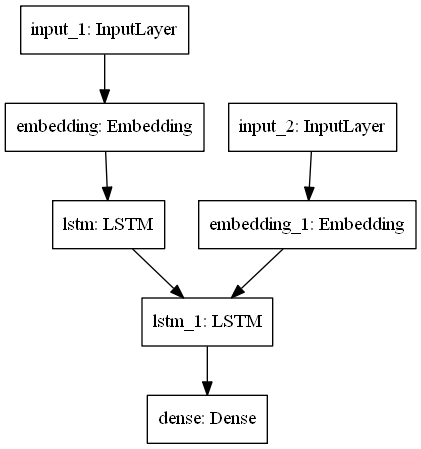

In [8]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

from keras.utils import plot_model
plot_model(model,to_file='model.png')

In [9]:
from keras.callbacks import ModelCheckpoint

filepath = 'model.best.h5'
# 有一次提升, 则覆盖一次.
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max', save_freq=1)
callbacks_list = [checkpoint]
# https://keras.io/api/callbacks/model_checkpoint/


history = model.fit(x=[encoder_input_data, decoder_input_data], y=decoder_output_data,
                    batch_size=128, epochs=50, validation_split=0.1,
                    callbacks=callbacks_list)
model.save('model.h5')


Epoch 00001: accuracy improved from -inf to 0.00000, saving model to model.best.h5
  1/141 [..............................] - ETA: 0s - loss: 2.8163 - accuracy: 0.0000e+00
Epoch 00001: accuracy improved from 0.00000 to 0.00807, saving model to model.best.h5
  2/141 [..............................] - ETA: 2:31 - loss: 2.8444 - accuracy: 0.0081  
Epoch 00001: accuracy improved from 0.00807 to 0.02517, saving model to model.best.h5
  3/141 [..............................] - ETA: 2:46 - loss: 2.8662 - accuracy: 0.0252
Epoch 00001: accuracy improved from 0.02517 to 0.03555, saving model to model.best.h5
  4/141 [..............................] - ETA: 2:48 - loss: 2.8566 - accuracy: 0.0355
Epoch 00001: accuracy improved from 0.03555 to 0.04177, saving model to model.best.h5
  5/141 [>.............................] - ETA: 2:53 - loss: 2.8497 - accuracy: 0.0418
Epoch 00001: accuracy improved from 0.04177 to 0.04592, saving model to model.best.h5
  6/141 [>.............................] - ETA:

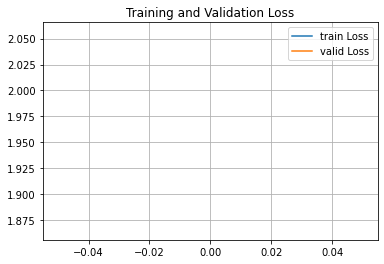

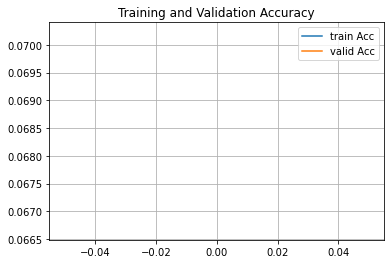

In [10]:
import pandas as pd
from matplotlib import pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(loss, label='train Loss')
plt.plot(val_loss, label='valid Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(acc, label='train Acc')
plt.plot(val_acc, label='valid Acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [11]:
from keras.models import load_model
model = load_model('model.best.h5')

encoder_model = Model(encoder_inputs, encoder_states) # 输入（带embedding），输出思想向量

decoder_state_input_h = Input(shape=(rnn_size,))
decoder_state_input_c = Input(shape=(rnn_size,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(decoder_after_embedding,
                                                             initial_state=decoder_states_inputs)
decoder_states_inf = [state_h_inf, state_c_inf]
decoder_outputs_inf = decoder_dense(decoder_outputs_inf)

In [12]:
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs_inf] + decoder_states_inf
)


In [14]:
# 采样
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = outputToken_idx['BEGIN_']
    stop = False
    decoded_sentence = ''
    while not stop:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)
        sampled_token_idx = np.argmax(output_tokens)
        sampled_word = idx_outputToken[sampled_token_idx]
        decoded_sentence += ' ' + sampled_word

        if sampled_word == '_END' or len(decoded_sentence) > 60:
            stop = True
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_idx
        # Update states
        states_value = [h, c]

    return decoded_sentence


# 简单测试 采样
text_to_translate = 'Are you happy ?'
encoder_input_to_translate = np.zeros(
    (1, max_input_seq_len),
    dtype=np.float32)
for t, word in enumerate(text_to_translate.split()):
    encoder_input_to_translate[0, t] = inputToken_idx[word]

print(decode_sequence(encoder_input_to_translate))

 _END
